# Prepare for data import
The Movie dataset is picked from GroupLens at this [link](https://grouplens.org/datasets/movielens/latest/) (the smaller version).  
Dimensions of the dataset is: 4k movies, 6k users and 1M ratings.  
The files inside the zip directory are: 
- `users.csv`: list of users with userId, gender, age and occupation
- `movies.csv`: lists of movies with movieId, name, genres list
- `ratings.csv`: list of ratings from users with userId, movieId, rating and timestamp

Datasets file was in .bat extension so it be done some steps to convert in CSV:
- Remove all `,` character.
- Convert actual delimiter `::` to `,`
- Added headers according to README info   

Data are normalized pretty well but a user table (not present for privacy reasons) and a table specifically for genders will be created in order to do better graph analytics.  

## Load data
Starting with load data from dir specified on `source_dataset`.  
It is specified dtype on dataframe import for better performance. 

In [98]:
import pandas as pd
import numpy as np

source_dataset = "dataset/ml-1m"

movies = pd.read_csv(
    f"{source_dataset}/movies.csv",
    dtype={"movieId": np.int32, "title": str, "genres": str},
)
ratings = pd.read_csv(
    f"{source_dataset}/ratings.csv",
    dtype={
        "userId": np.int32,
        "movieId": np.int32,
        "rating": np.int8,
        "timestamp": np.float64,
    },
)
users = pd.read_csv(
    f"{source_dataset}/users.csv",
    dtype={
        "userId": np.int32,
        "gender": str,
        "age": np.int8,
        "occupation": np.int8,
    },
)

# tags = pd.read_csv(
#     f"{source_dataset}/tags.csv",
#     dtype={
#         "userId": np.int32,
#         "movieId": np.int32,
#         "tag": str,
#         "timestamp": np.float64,
#     },
# )

## Check data quality

### Movies
In movies dataframe it can see that we have not null values and movieIds are unique.  
It can see that titles can has inside year info.  
In genres there's a list of genres that could be an other table.

In [99]:
print(f"Movies size is {movies.shape}")
print(f"Unique movieIds? {movies['movieId'].nunique() == movies.shape[0]}")
print(f"Unique titles? {movies['title'].nunique() == movies.shape[0]}")

movies.info()
movies.head()

Movies size is (3883, 3)
Unique movieIds? True
Unique titles? True
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  3883 non-null   int32 
 1   title    3883 non-null   object
 2   genres   3883 non-null   object
dtypes: int32(1), object(2)
memory usage: 76.0+ KB


,movieId,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


### Ratings
In the ratings dataframe it can see that all ratings are in the range 0 to 5 (with step of 0.5 according with readme of dataset).  
There's a timestamp field that will be formatted

In [100]:
print(f"\nRatings size is {ratings.shape}")
print(f"Are there any negative ratings? {ratings[ratings['rating']<0].size!=0}")
print(f"Are there any voting above 5? {ratings[ratings['rating']>5].size!=0}\n")

ratings.info()
ratings.head()


Ratings size is (1000209, 4)
Are there any negative ratings? False
Are there any voting above 5? False

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   userId     1000209 non-null  int32  
 1   movieId    1000209 non-null  int32  
 2   rating     1000209 non-null  int8   
 3   timestamp  1000209 non-null  float64
dtypes: float64(1), int32(2), int8(1)
memory usage: 16.2 MB


,userId,movieId,rating,timestamp
0,1,1193,5,978300760.0
1,1,661,3,978302109.0
2,1,914,3,978301968.0
3,1,3408,4,978300275.0
4,1,2355,5,978824291.0


### Users


In [101]:
print(f"\nUsers size is {users.shape}")
print(f"Unique userIds? {users['userId'].nunique() == users.shape[0]}")
print(f"Genders types: {users['gender'].value_counts().shape[0]}")
print(f"Age types: {users['age'].value_counts().shape[0]}")
print(f"Occupation types: {users['occupation'].value_counts().shape[0]}\n")
# Remove zip code because it is not useful
users.drop(columns=["zip_code"], inplace=True)

users.info()
users.head()


Users size is (6040, 5)
Unique userIds? True
Genders types: 2
Age types: 7
Occupation types: 21

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   userId      6040 non-null   int32 
 1   gender      6040 non-null   object
 2   age         6040 non-null   int8  
 3   occupation  6040 non-null   int8  
dtypes: int32(1), int8(2), object(1)
memory usage: 82.7+ KB


,userId,gender,age,occupation
0,1,F,1,10
1,2,M,56,16
2,3,M,25,15
3,4,M,45,7
4,5,M,25,20


## Transform data

### Extract year information from movie's title
Every title of datasets have year info on its title, so it is extracted for better analysis

Movies with no year: 0


<Axes: >

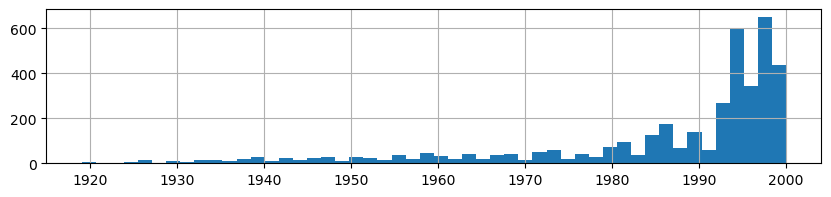

In [102]:
movies_year = movies["title"].str.extract(r"\((\d{4})\)")
print(f"Movies with no year: {movies_year.isna().any().sum()}")
movies["year"] = movies_year.astype(int)
movies["year"].hist(bins=50, figsize=(10, 2))

### Add genre nodes

In [103]:
movies["genres"] = movies["genres"].str.split("|")
movies_genres = movies[["movieId", "genres"]].explode("genres")
genres = movies_genres["genres"].value_counts().index.to_list()

# include integer ids for genres
movies_genres["genreId"] = movies_genres["genres"].apply(lambda x: genres.index(x) + 1)

# remove unuseful columns
movies.drop(columns=["genres"], inplace=True)
movies_genres.drop(columns=["genres"], inplace=True)

# create genre nodes
genres = pd.DataFrame(genres, columns=["name"])
genres["genreId"] = genres.index + 1
genres = genres.reindex(columns=["genreId", "name"])

genres

,genreId,name
0,1,Drama
1,2,Comedy
2,3,Action
3,4,Thriller
4,5,Romance
5,6,Horror
6,7,Adventure
7,8,Sci-Fi
8,9,Children's
9,10,Crime


In [104]:
movies_genres

,movieId,genreId
0,1,15
0,1,9
0,1,2
1,2,7
1,2,9
...,...,...
3879,3949,1
3880,3950,1
3881,3951,1
3882,3952,1


### Format raiting's timestamp 
It be converted timestamp in seconds to datetime ISO 8601.  
In this way it could be used in Neo4j db

In [105]:
ratings["timestamp"] = pd.to_datetime(
    ratings["timestamp"], unit="s", utc=True
).dt.strftime("%Y-%m-%dT%H:%M:%S%z")

# Data are ready, move to docker volume


Dataset is not to big but 1M ratings make the import slowly (more than 30 minutes).  
So it be prefer to use [neo4j-admin-import](https://neo4j.com/docs/operations-manual/current/tools/neo4j-admin/neo4j-admin-import)  
In this cell it be formatted file following the [docs](https://neo4j.com/docs/operations-manual/current/tools/neo4j-admin/neo4j-admin-import/#import-tool-header-format).  

N.B.: if you want import data in classical way (LOAD CSV with Cypher), DON'T RUN this cell and go to [classical_import](1_classical_import.ipynb)

In [106]:
movies.columns = ["movieId:ID(Movie-ID)", "title", "year:int"]
movies[":LABEL"] = "Movie"

users.columns = ["userId:ID(User-ID)", "gender:string", "age:int", "occupation:int"]
users[":LABEL"] = "User"

genres.columns = ["genreId:ID(Genre-ID)", "name:string"]
genres[":LABEL"] = "Genre"

ratings.columns = [
    "userId:START_ID(User-ID)",
    "movieId:END_ID(Movie-ID)",
    "rating:int",
    "timestamp:datetime",
]
ratings[":TYPE"] = "RATED"

movies_genres.columns = [
    "movieId:START_ID(Movie-ID)",
    "genreId:END_ID(Genre-ID)",
]
movies_genres[":TYPE"] = "IN_GENRE"

In [108]:
import os

path_to_save = "clean_data/new"


if not os.path.exists(path_to_save):
    os.makedirs(path_to_save)

movies.to_csv(f"{path_to_save}/movies.csv", index=False)
users.to_csv(f"{path_to_save}/users.csv", index=False)
genres.to_csv(f"{path_to_save}/genres.csv", index=False)

ratings.to_csv(f"{path_to_save}/ratings.csv", index=False)
movies_genres.to_csv(f"{path_to_save}/movies_genres.csv", index=False)